In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt

## Importing Data

In [6]:
def read_file(file_name: str)-> pd.DataFrame:
    '''
        Return data frame
    '''
    return pd.read_csv(f'../data/{file_name}.csv')

In [7]:
df = read_file('petr4')

## Exploring Data

In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,5.875,5.875,5.875,5.875,3.598475,3.538944e+10
1,2000-01-04,5.550,5.550,5.550,5.550,3.399409,2.886144e+10
2,2000-01-05,5.494,5.494,5.494,5.494,3.365109,4.303360e+10
3,2000-01-06,5.475,5.475,5.475,5.475,3.353472,3.405568e+10
4,2000-01-07,5.500,5.500,5.500,5.500,3.368783,2.091264e+10


In [9]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5488.000000,5488.000000,5488.000000,5488.000000,5488.000000,5.488000e+03
mean,18.422982,18.692974,18.128320,18.392648,13.964711,5.847036e+08
std,9.451948,9.598134,9.283075,9.416264,7.507482,4.034349e+09
min,4.200000,4.270000,4.120000,4.200000,2.679715,0.000000e+00
25%,9.748125,9.939375,9.550000,9.748125,6.954027,2.068462e+07
50%,18.530001,18.850000,18.209999,18.500000,14.160834,3.245170e+07
75%,24.910000,25.412500,24.600000,24.978750,19.424093,5.220082e+07
max,67.500000,67.500000,51.950001,52.509998,36.098503,7.356416e+10


In [10]:
#Checking for null values and types
pd.DataFrame({
        'NaN Count': df.isna().sum(),
        'NaN %': np.round(100*df.isna().sum()/df.shape[0],2),
        'Types': df.dtypes
    
})

,NaN Count,NaN %,Types
Date,0,0.00,object
Open,5,0.09,float64
High,5,0.09,float64
Low,5,0.09,float64
Close,5,0.09,float64
Adj Close,5,0.09,float64
Volume,5,0.09,float64


## Pre-processing

In [11]:
def convert_date_time(cols: list, df: pd.DataFrame)-> pd.DataFrame:
    '''
        Convert column to datetime
    '''
    for col_name in cols:
        df[col_name] = pd.to_datetime(df[col_name])
    return df

In [12]:
df = convert_date_time(['Date'],df)

In [13]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

In [14]:
def sorting(df: pd.DataFrame,col_name: str)->pd.DataFrame:
    '''
        Sorting Data
    '''
    df.set_index(col_name,inplace=True)
    df=df.sort_index()
    return df

In [15]:
df = sorting(df,'Date')

In [16]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-01,27.709999,28.320000,27.370001,28.000000,28.000000,102157200.0
2021-11-03,27.709999,27.850000,26.799999,26.850000,26.850000,83475800.0
2021-11-04,27.020000,27.240000,25.850000,26.000000,26.000000,92603400.0
2021-11-05,26.290001,26.540001,25.780001,25.850000,25.850000,86264000.0
2021-11-08,25.809999,26.660000,25.719999,26.120001,26.120001,59704100.0


## Undestanding data

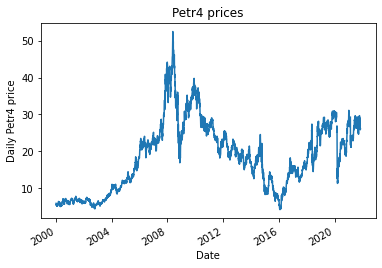

In [17]:
data = df.copy()
data['Close'].plot()
plt.ylabel("Daily PETR4 price")
plt.title('PETR4 prices')
plt.show()


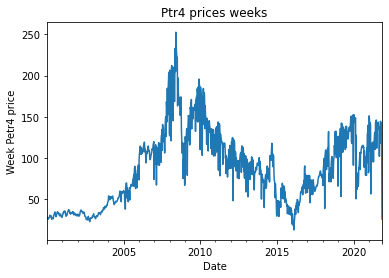

In [18]:
data['Close'].resample('W').sum().plot()
plt.ylabel("Week PETR4 price")
plt.title('PETR4 prices weeks')
plt.show()

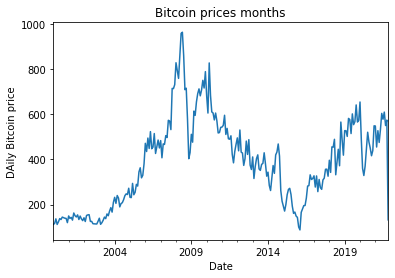

In [19]:
data['Close'].resample('M').sum().plot()
plt.ylabel("Daily PETR4 price")
plt.title('PETR4 prices months')
plt.show()

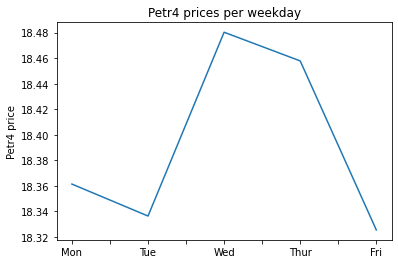

In [20]:
weekday=data.groupby(data.index.dayofweek)['Close'].mean()
weekday.index = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri' ]
weekday.plot()
plt.ylabel("Petr4 price")
plt.title('Petr4 prices per weekday')
plt.show()

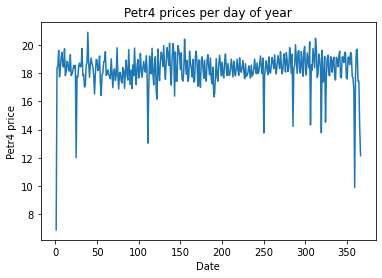

In [21]:
data.groupby(data.index.dayofyear)['Close'].mean().plot()
plt.ylabel("Petr4 price")
plt.title('Petr4 prices per day of year')
plt.show()

# Forecast

## Baseline Model: Shift 

<AxesSubplot:xlabel='Date'>

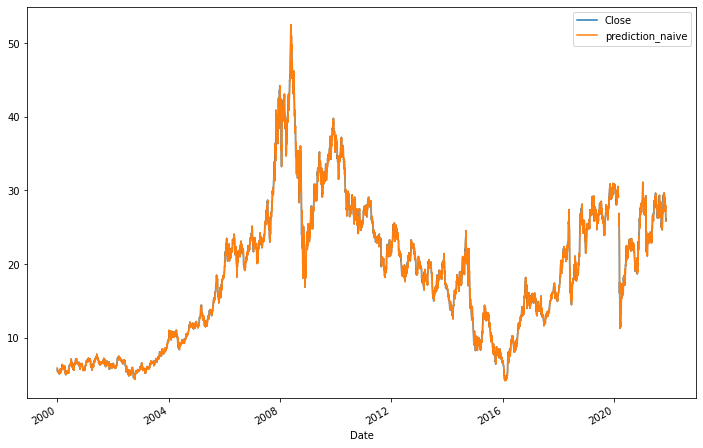

In [22]:
data['prediction_naive']=data['Close'].shift(1)
data[['Close','prediction_naive']].plot(figsize=(12,8))

In [23]:
#np.sqrt(mean_squared_error(data['Close'][1:],data['prediction_naive'][1:]))

Apesar do bom resultado o modelo Baseline não consegue aprender sobre o histórico e refletir esses dados no futuro, a composição do preço depende de fatores externos como sazonalidadedes, tendência e erro.

## Forecast Using Prophet

In [24]:
from prophet import Prophet


In [25]:
def prepare_forecast(target_y, df)->pd.DataFrame:
    df=df[[target_y]]
    df=df.reset_index()
    df.columns=['ds','y']
    return df

In [26]:
df = prepare_forecast('Close', df)

In [27]:
df

,ds,y
0,2000-01-03,5.875000
1,2000-01-04,5.550000
2,2000-01-05,5.494000
3,2000-01-06,5.475000
4,2000-01-07,5.500000
...,...,...
5488,2021-11-01,28.000000
5489,2021-11-03,26.850000
5490,2021-11-04,26.000000
5491,2021-11-05,25.850000


In [28]:
#Instantiating the model and performing the fit
model= Prophet( 
            interval_width=0.95,
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True,
            
            )
model.fit(df)

In [29]:
#Make futre
future = model.make_future_dataframe(periods=1095, freq='D')
forecast = model.predict(future)

In [30]:
#yhat is the estimated value for the next 500 days
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6583,2024-11-03,35.979995,-6.006725,78.830916
6584,2024-11-04,36.317240,-5.363550,78.499048
6585,2024-11-05,36.324096,-6.281602,78.391562
6586,2024-11-06,36.350832,-5.378905,76.881245
6587,2024-11-07,36.369784,-6.296240,79.955662


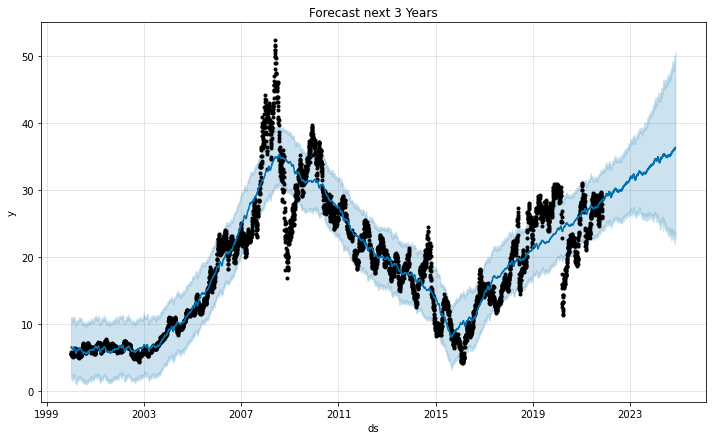

In [48]:
#Ploting data
model.plot(forecast)
plt.title('Forecast next 3 Years')
plt.show()

In [32]:
#Ploting compenents

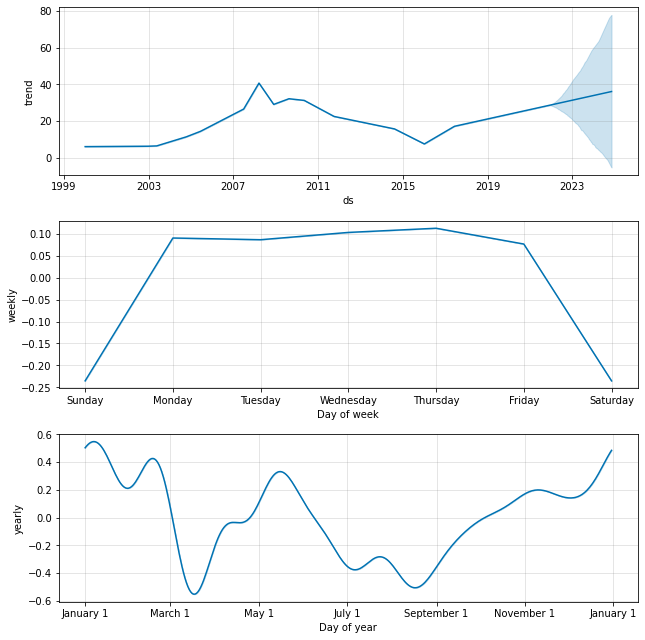

In [33]:
model.plot_components(forecast)
plt.show()

## Métricas do modelo

### Cross validation

In [34]:
from prophet.diagnostics import cross_validation

In [35]:
df_cv=cross_validation(model,horizon="365 days",period='180 days',initial='1095 days')


INFO:prophet:Making 37 forecasts with cutoffs between 2003-02-11 00:00:00 and 2020-11-08 00:00:00


  0%|          | 0/37 [00:00<?, ?it/s]

In [36]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2003-02-12,5.905036,5.237901,6.573460,5.85625,2003-02-11
1,2003-02-13,5.932878,5.229962,6.654530,5.77500,2003-02-11
2,2003-02-14,5.948775,5.249676,6.658149,5.73375,2003-02-11
3,2003-02-17,6.019388,5.331035,6.730240,5.77500,2003-02-11
4,2003-02-18,6.045944,5.320656,6.756558,5.74000,2003-02-11


In [37]:
# Performance metrics
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,19.617362,4.429149,3.070611,0.162425,0.108876,0.156345,0.673920
1,38 days,19.650972,4.432942,3.078140,0.162903,0.108876,0.156848,0.671734
2,39 days,19.560531,4.422729,3.079254,0.163323,0.108643,0.157265,0.670045
3,40 days,19.502291,4.416140,3.083970,0.164497,0.109230,0.158239,0.667800
4,41 days,19.699014,4.438357,3.110550,0.166573,0.109703,0.160246,0.664224


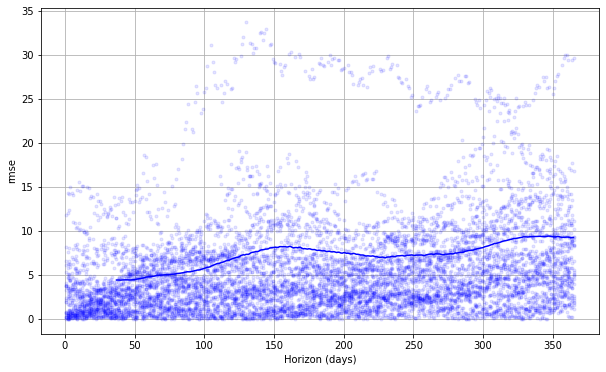

In [38]:
from prophet.plot import plot_cross_validation_metric
fig=plot_cross_validation_metric(df_cv,metric='rmse')


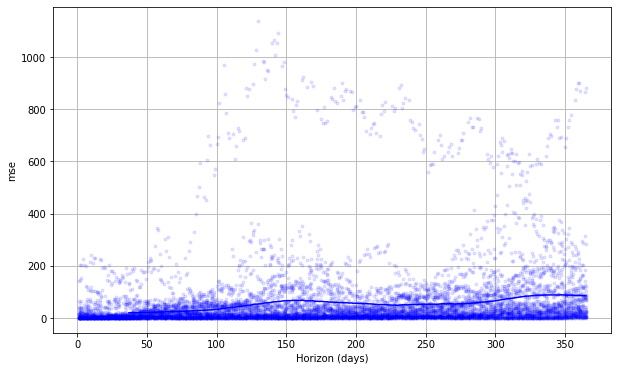

In [39]:
fig=plot_cross_validation_metric(df_cv,metric='mse')

### Undestand relavants points


In [40]:
from prophet.plot import add_changepoints_to_plot


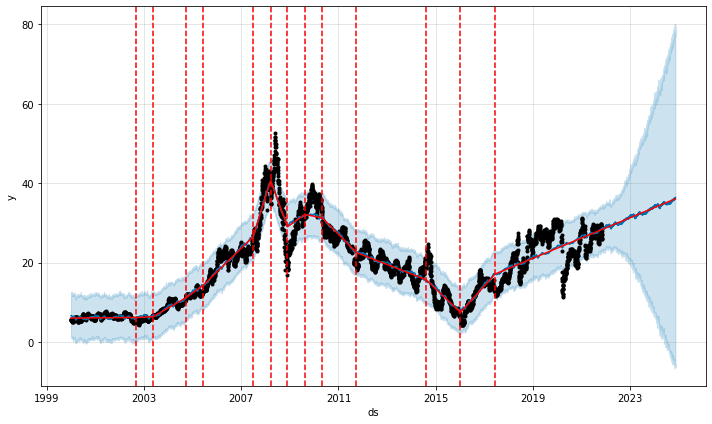

In [41]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [42]:
model.changepoints

176    2000-09-05
351    2001-05-08
527    2002-01-09
702    2002-09-11
878    2003-05-15
1053   2004-01-15
1229   2004-09-17
1404   2005-05-31
1580   2006-02-08
1756   2006-10-12
1931   2007-06-27
2107   2008-03-18
2282   2008-11-26
2458   2009-08-13
2633   2010-05-03
2809   2011-01-14
2985   2011-09-28
3160   2012-06-14
3336   2013-03-06
3511   2013-11-12
3687   2014-08-05
3862   2015-04-17
4038   2016-01-06
4213   2016-09-16
4389   2017-06-05
Name: ds, dtype: datetime64[ns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


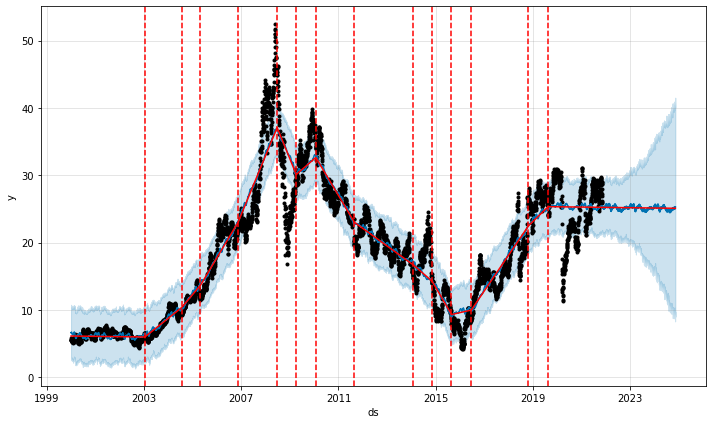

In [43]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(df).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


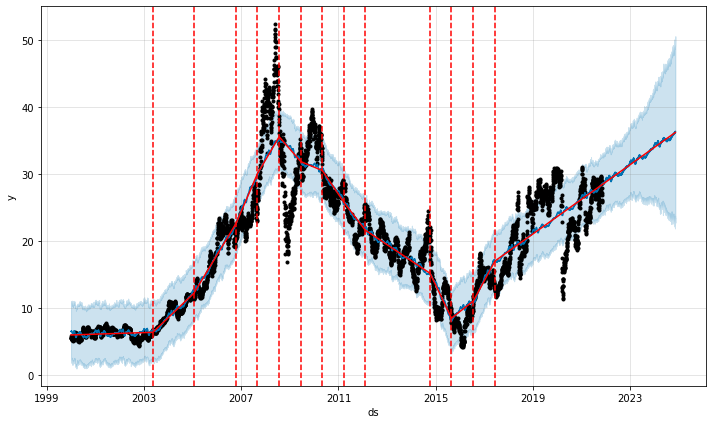

In [44]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(df).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

## Export model

In [45]:
import joblib

In [46]:
joblib.dump(model, '../models/model.pkl')

['../models/model.pkl']